# Imports

In [1]:
import pandas as pd
from nltk.tokenize                   import RegexpTokenizer
from bs4                             import BeautifulSoup  
from nltk.corpus                     import stopwords
from sklearn.linear_model            import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline                import Pipeline,FeatureUnion
from sklearn.model_selection         import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics                 import confusion_matrix,classification_report
import warnings

warnings.filterwarnings("ignore")

In [30]:
df = pd.read_csv('../datasets/clean_tweets.csv')
df

,username,text,date,clean_text,target,lat,long
0,Waldemar Gonzalez,"No work for a week due to power outage, trip t...",2018-03-05,work week due power outage trip miami sounds l...,1,42.351035,-71.098957
1,oldschool,Really. !! NYSEG needs leadership. Is this yo...,2018-03-05,really nyseg needs leadership first power outa...,1,42.375944,-71.203094
2,Deanna,Aaaand they left without doing anything. The o...,2018-03-05,aaaand left without anything outage map longer...,1,42.361009,-71.150891
3,Rose,Power Outage waste: \n school cafeteria where...,2018-03-05,power outage waste school cafeteria line dance...,1,42.332771,-71.175588
4,LocoMoco Guy,Tried calling the toll free number. No chance ...,2018-03-05,tried calling toll free number chance talk liv...,1,42.348956,-71.006838
...,...,...,...,...,...,...,...
1054,[Tity Bear],Tfw there's a company-wide network outage and ...,2017-07-21,tfw company wide network outage work coming al...,0,42.320828,-71.034768
1055,Abha Azad,"#AirtelWoes: for over 6 hours today, no servic...",2018-08-23,airtelwoes 6 hours today service mobile sim th...,0,42.256383,-71.078822
1056,Whitney,The power outage ruined my motivation to do ho...,2018-02-20,power outage ruined motivation homework got ho...,0,42.266296,-71.092543
1057,Michele Rion,What the heck @AT&T no service in Fort Worth! ...,2014-09-24,heck service fort worth phone text nothing out...,0,42.289356,-71.154900


# PreProcessing

In [9]:
df.isnull().sum()

username      0
text          0
date          0
clean_text    0
target        0
lat           0
long          0
dtype: int64

In [10]:
df.dropna(how='any',inplace=True)

In [11]:
df.isnull().sum()

username      0
text          0
date          0
clean_text    0
target        0
lat           0
long          0
dtype: int64

In [12]:
df.shape

(1059, 7)

In [13]:
X = df['clean_text']
y=df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, stratify = y)

In [14]:
#Keep a vectorized DF for the records
cvec = CountVectorizer(max_df= 0.9,min_df=0.0012,ngram_range=(1,1))
cvec.fit(X_train)
DF = cvec.transform(X_train)
DF = pd.DataFrame(DF.toarray(),
                          columns=cvec.get_feature_names())

In [15]:
DF.shape

(741, 3505)

In [16]:
DF.to_csv('../datasets/countvec_words.csv')

# Model Set Up

In [17]:
# Define Pipeline
pipe = Pipeline(steps = [('vectorizer', CountVectorizer()),     # first tuple is for first step: vectorizer
                         ('model', LogisticRegression())        # second tuple is for second step: model
                        ])    

# Construct Grid Parameters
hyperparams = {'vectorizer__ngram_range': [(1,1), (2,2), (1,2)],
               'vectorizer__max_df': [0.9, 0.8, 1],
               'vectorizer__min_df':[0.0012],

               'model__penalty': ['l1', 'l2'],
               'model__C': [0.1, 1, 3, 10],
               'model__max_iter':[50,100,150]
            
              }

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
results = gs.fit(X_train, y_train)

# Get best params
results.best_estimator_

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=None, min_df=0.0012,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('model',
                 LogisticRegression(C=3, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=50,
                                    multi_class='warn', n_jobs=None,
                

In [18]:
vectorizer_params = results.best_estimator_.steps[0][1].get_params()
model_params = results.best_estimator_.steps[1][1].get_params()

# Get score
train_score = results.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score))
test_score = results.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))
results.best_params_

Best TRAIN accuracy: 0.9487
Best TEST set accuracy: 0.9465


{'model__C': 3,
 'model__max_iter': 50,
 'model__penalty': 'l2',
 'vectorizer__max_df': 0.9,
 'vectorizer__min_df': 0.0012,
 'vectorizer__ngram_range': (1, 1)}

In [19]:
pipe = Pipeline(steps = [('cv', CountVectorizer(max_df= 0.9,min_df=0.001,ngram_range=(1,1))),
                         ('model', LogisticRegression(C=0.1,max_iter=50,penalty='l1')),     
                        ])    

# Model Evaluation

In [20]:
#Get predictions and probabilities
results = pipe.fit(X_train, y_train);
pred=pipe.predict(X_test)
pred_proba=pipe.predict_proba(X_test)

In [21]:
#Confusion Matrix
cm=confusion_matrix(y_test, pred)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt=".1f", cmap='YlOrBr', cbar=False); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Power Outage', 'Power Outage']); ax.yaxis.set_ticklabels(['No Power Outage', 'Power Outage']);

In [23]:
#Classification Report
from sklearn.metrics import classification_report
thresh = .7
print(classification_report(y_test, pred_proba[:, 1]>thresh))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       300
           1       0.00      0.00      0.00        18

    accuracy                           0.94       318
   macro avg       0.47      0.50      0.49       318
weighted avg       0.89      0.94      0.92       318



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.596


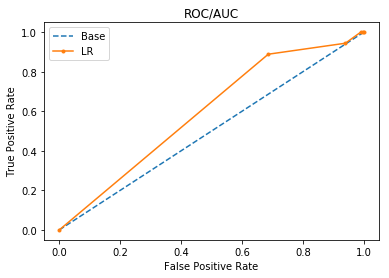

In [24]:
#ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]

pipe_probs = pipe.predict_proba(X_test)
pipe_probs = pipe_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
pipe_auc = roc_auc_score(y_test, pipe_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (pipe_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pipe_fpr, pipe_tpr, _ = roc_curve(y_test, pipe_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
plt.plot(pipe_fpr, pipe_tpr, marker='.', label='LR')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
plt.title('ROC/AUC')

# show the plot
plt.show()

In [25]:
#Saving predictions
pred_train=pd.DataFrame(pipe.predict(X_train))
pred_train['origin']='train'
pred_test=pd.DataFrame(pipe.predict(X_test))
pred_test['origin']='test'

In [27]:
pred_test

,0,origin
0,0,test
1,0,test
2,0,test
3,0,test
4,0,test
...,...,...
313,0,test
314,0,test
315,0,test
316,0,test


In [29]:
pred_test['index']= 

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
pred_test.to_csv('../datasets/preds_index.csv')

In [ ]:
all_preds=pd.concat([pred_train,pred_test], axis=0,ignore_index=True)

In [ ]:
all_preds.rename(columns={0:'preds','origin':'origin'},inplace=True)

In [ ]:
pd.concat([df,all_preds]);

In [ ]:
df.to_csv('../datasets/tweets_and_preds.csv')